In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import torch.nn.functional as F


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
random_seed=42

In [4]:
train_dir = '/kaggle/input/animal-faces/afhq/train'
valid_dir = '/kaggle/input/animal-faces/afhq/val'

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root=train_dir, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder(root=valid_dir, transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s] 


In [8]:
# 리스트 초기화
train_losses = []
val_losses = []
best_val_loss = float('inf')  # 초기값을 무한대로 설정

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = train_loss / len(train_loader)
    accuracy_train = correct_train / total_train

    # 검증 단계
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        for inputs, labels in tqdm(val_loader, desc=f'Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        average_val_loss = val_loss / len(val_loader)
        accuracy_val = correct_val / total_val

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {average_train_loss}, Train Accuracy: {accuracy_train}, '
              f'Val Loss: {average_val_loss}, Val Accuracy: {accuracy_val}')
        
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # 로스 기록
        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)

Validation: 100%|██████████| 47/47 [00:20<00:00,  2.32it/s]


Epoch [1/10], Train Loss: 0.12812782149338955, Train Accuracy: 0.9548872180451128, Val Loss: 0.07824319634342596, Val Accuracy: 0.976


Validation: 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


Epoch [2/10], Train Loss: 0.07269089016466052, Train Accuracy: 0.9751196172248804, Val Loss: 1.117410451974952, Val Accuracy: 0.782


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.46it/s]


Epoch [3/10], Train Loss: 0.04291789016797457, Train Accuracy: 0.9855092276144908, Val Loss: 0.06308802423681774, Val Accuracy: 0.984


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Epoch [4/10], Train Loss: 0.046771367174207476, Train Accuracy: 0.9846889952153111, Val Loss: 0.07154733830619545, Val Accuracy: 0.9746666666666667


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Epoch [5/10], Train Loss: 0.03572054270142867, Train Accuracy: 0.9879015721120984, Val Loss: 0.04628772737995919, Val Accuracy: 0.9906666666666667


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


Epoch [6/10], Train Loss: 0.028981082281374193, Train Accuracy: 0.989542036910458, Val Loss: 0.04211411015226278, Val Accuracy: 0.9846666666666667


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


Epoch [7/10], Train Loss: 0.02710139377458048, Train Accuracy: 0.9908407382091593, Val Loss: 0.17171665631920338, Val Accuracy: 0.958


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


Epoch [8/10], Train Loss: 0.02376376218638234, Train Accuracy: 0.991455912508544, Val Loss: 0.14796439147727733, Val Accuracy: 0.9526666666666667


Validation: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Epoch [9/10], Train Loss: 0.02323495490649428, Train Accuracy: 0.9925495557074504, Val Loss: 0.03865295314997238, Val Accuracy: 0.9886666666666667


Validation: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]

Epoch [10/10], Train Loss: 0.025286508251667533, Train Accuracy: 0.9920710868079289, Val Loss: 0.6031363006567265, Val Accuracy: 0.8226666666666667


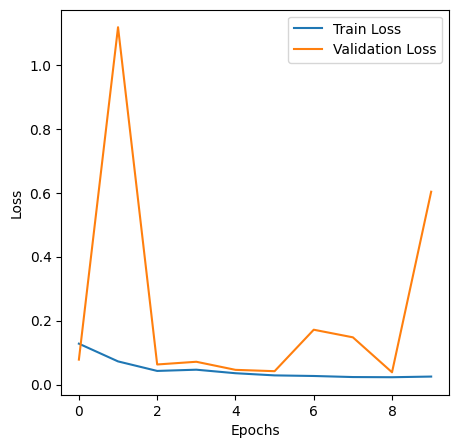

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_dataset = ImageFolder(root="/kaggle/input/predict-set", transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

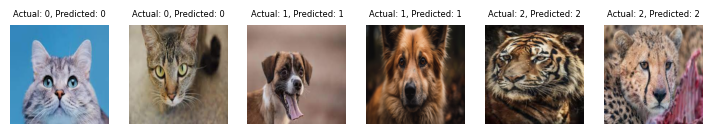

In [11]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

for inputs, labels in test_loader:
    # GPU로 데이터 옮기기
    inputs, labels = inputs.to(device), labels.to(device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # 미니배치의 이미지, 실제 라벨, 예측 결과 출력
    plt.figure(figsize=(12, 6))
    for i in range(inputs.size(0)):
        plt.subplot(4, 8, i+1)
        plt.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())
        actual_class = labels[i].item()
        predicted_class = predicted[i].item()
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}",fontsize=6)
        plt.axis("off")

    plt.show()